In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [3]:
!mkdir -p /kaggle/temp/
!unzip ../input/dogs-vs-cats/test1.zip -d /kaggle/temp/
!unzip ../input/dogs-vs-cats/train.zip -d /kaggle/temp/

Archive:  ../input/dogs-vs-cats/test1.zip
   creating: /kaggle/temp/test1/
  inflating: /kaggle/temp/test1/1.jpg  
  inflating: /kaggle/temp/test1/10.jpg  
  inflating: /kaggle/temp/test1/100.jpg  
  inflating: /kaggle/temp/test1/1000.jpg  
  inflating: /kaggle/temp/test1/10000.jpg  
  inflating: /kaggle/temp/test1/10001.jpg  
  inflating: /kaggle/temp/test1/10002.jpg  
  inflating: /kaggle/temp/test1/10003.jpg  
  inflating: /kaggle/temp/test1/10004.jpg  
  inflating: /kaggle/temp/test1/10005.jpg  
  inflating: /kaggle/temp/test1/10006.jpg  
  inflating: /kaggle/temp/test1/10007.jpg  
  inflating: /kaggle/temp/test1/10008.jpg  
  inflating: /kaggle/temp/test1/10009.jpg  
  inflating: /kaggle/temp/test1/1001.jpg  
  inflating: /kaggle/temp/test1/10010.jpg  
  inflating: /kaggle/temp/test1/10011.jpg  
  inflating: /kaggle/temp/test1/10012.jpg  
  inflating: /kaggle/temp/test1/10013.jpg  
  inflating: /kaggle/temp/test1/10014.jpg  
  inflating: /kaggle/temp/test1/10015.jpg  
  inflating:

In [4]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [5]:
filenames = os.listdir("../temp/train")
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df

,filename,category
0,dog.890.jpg,1
1,dog.1178.jpg,1
2,dog.7845.jpg,1
3,dog.4632.jpg,1
4,cat.3660.jpg,0
...,...,...
24995,dog.6505.jpg,1
24996,cat.3805.jpg,0
24997,cat.5513.jpg,0
24998,cat.6808.jpg,0


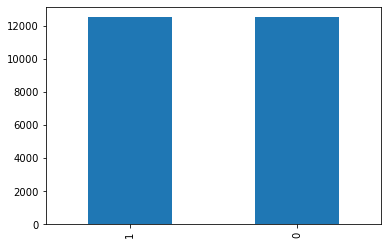

In [7]:
df['category'].value_counts().plot.bar()
plt.show()

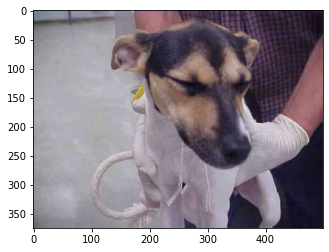

In [8]:
import random

sample = random.choice(filenames)
image = load_img("../temp/train/" + sample)
plt.imshow(image)
plt.show()

# Model

In [9]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation

model = Sequential()
model.add(Flatten(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax')) # only 2 classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1572896   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 1,572,962
Trainable params: 1,572,962
Non-trainable params: 0
_________________________________________________________________


# Callbacks

In [10]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(patience=10)

In [11]:
callbacks = [earlystop]

# Prepare data

In [12]:
df["category"]

0        1
1        1
2        1
3        1
4        0
        ..
24995    1
24996    0
24997    0
24998    0
24999    1
Name: category, Length: 25000, dtype: int64

In [13]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})
df["category"]

0        dog
1        dog
2        dog
3        dog
4        cat
        ... 
24995    dog
24996    cat
24997    cat
24998    cat
24999    dog
Name: category, Length: 25000, dtype: object

In [14]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

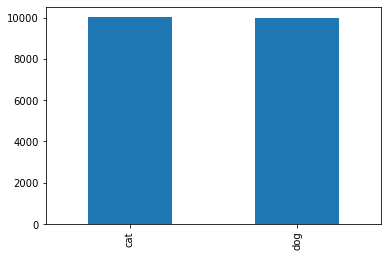

In [15]:
train_df['category'].value_counts().plot.bar()
plt.show()

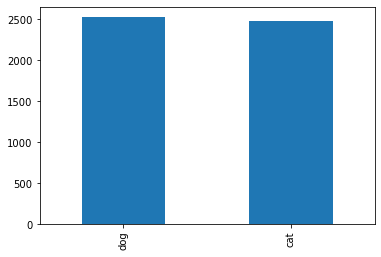

In [16]:
validate_df['category'].value_counts().plot.bar()
plt.show()

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=16

# Training Generator

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15, # 최대 15도 회전
    rescale=1./255, 
    shear_range=0.1, # 층 밀리기 강도
    zoom_range=0.2, # 무작위 줌 범위
    horizontal_flip=True, # 좌우 반전 가능
    width_shift_range=0.1, # 좌우 이동 최대 10프로 비율
    height_shift_range=0.1 # 상하 이동 최대 10프로 비율
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../temp/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../temp/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# See how generator works

In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../temp/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


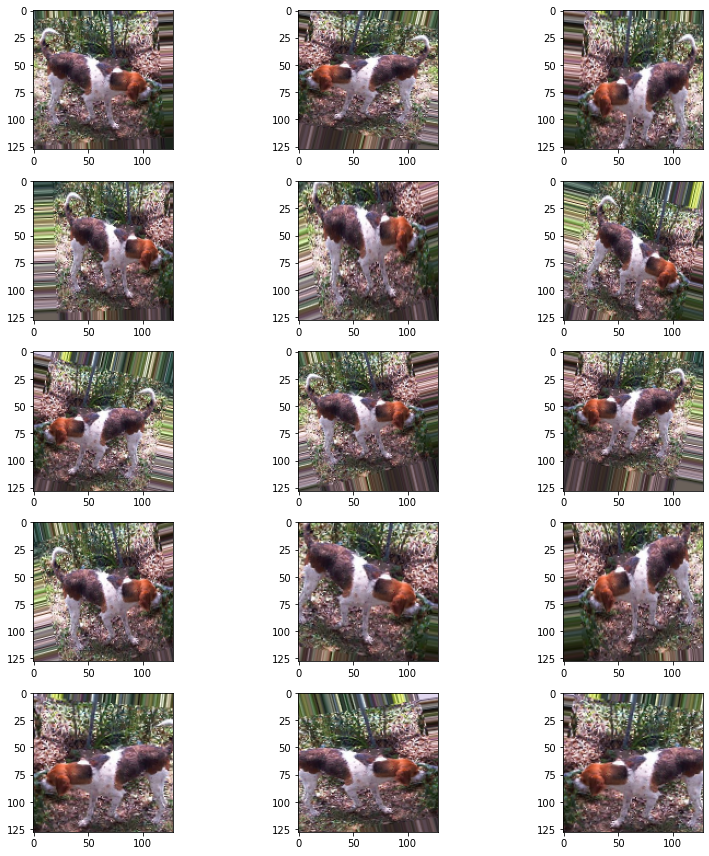

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit model

In [22]:
epochs = 2
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/2
1250/1250 [==============================] - 132s 105ms/step - loss: 0.7261 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.5052
Epoch 2/2
1250/1250 [==============================] - 133s 107ms/step - loss: 0.6932 - accuracy: 0.4968 - val_loss: 0.6931 - val_accuracy: 0.5052


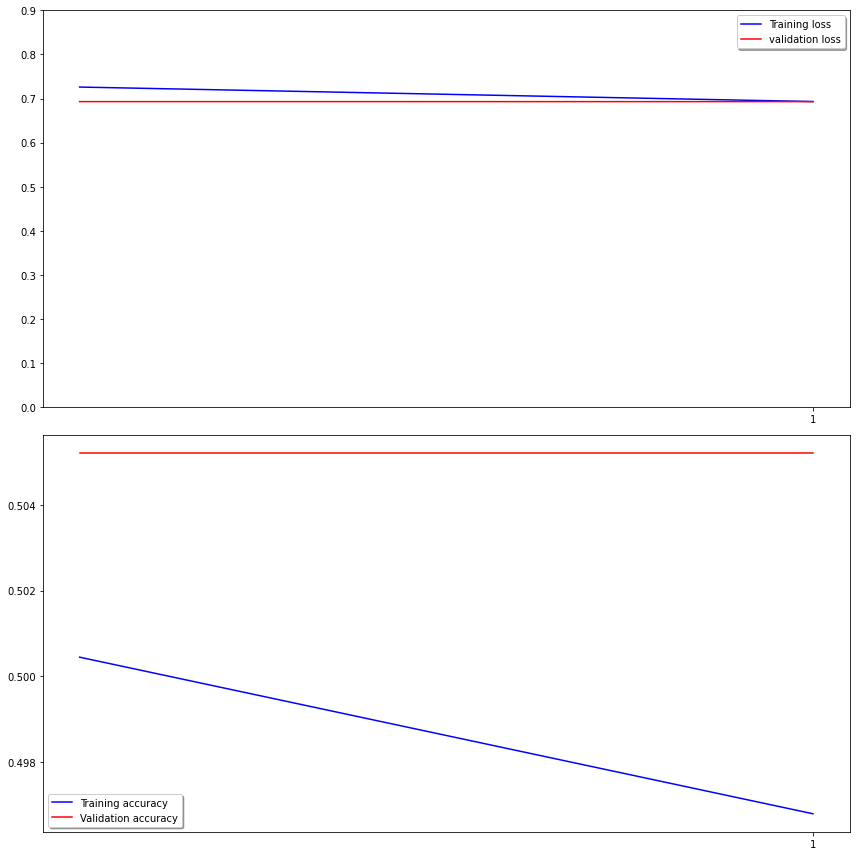

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(loc='best', shadow=True)

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()